In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.collections
from scipy.interpolate import interp1d
sns.set()
from results import load
from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from functions import *
#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

#avoid Font-problem in plots for ACM/IEEE papers
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

<ipython-input-1-ce831e714e12>:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from mpl_toolkits.axes_grid1.colorbar import colorbar


# Reading the results

In [2]:
#config
experiment_name = "acr"
load_raw = True
all = None
providers = None
num_repetitions = None
configs = None

if load_raw:

    providers = ["aws","gcf","ibm","azure"] 
    num_repetitions = 2
    configs = ["0,0,1","0,0,0.5","60,60,1","60,60,0.5","60,60,0"]


    all = load(experiment_name, providers,configs,num_repetitions,True)
    all.to_csv("results/acr.csv")
else :
    all = pd.read_csv("results/acr.csv")#
    providers = all["Provider"].unique()
    num_repetitions = all["run"].max()
    configs = all["WL"].unique()

all.columns

Index(['RId', 'WL', 'CId', 'CStart', 'ECost', 'DLat', 'ELat', 'RFailed',
       'Phase', 'RStart', 'EStart', 'EEnd', 'REnd', 'CNew', 'CPlat', 'TLat',
       'COs', 'RInput', 'Provider', 'Region', 'RLat', 'BLat', 'RResult', 'run',
       'sourceFile', 'RCode', 'RSuccessed', 'HIdOld', 'HId'],
      dtype='object')

### Styles and Constants

In [3]:
#sns.set_palette(sns.color_palette("Paired"))

palette = sns.color_palette().as_hex()
style = {
    "aws":{
        "name":"AWS",
        "color":palette[8]
    },
    "ibm":{
        "name":"ICF",
        "color":palette[1]
    },
    "gcf":{
        "name":"GCF",
        "color":palette[2]
    },
    "azure":{
        "name":"MAF",
        "color":palette[4]
    },
    "CNew":{
        "New":"#0485d1",
        "Cold":"#0485d1",
        "Reused": "#fc5a50",
        "Warm": "#fc5a50"
    },
    #colors
    "Lats":{
        "Delivery Latency":"#d1ffbd",
        "Request-Response Latency":"#448ee4",
        "Execution Latency":"#25a36f",
        "Backward Response Delivery Latency":"#89a203",
        "Delivery":"#89a203",
        "Delivery Latency":"#89a203",
        "Request-Response":"#448ee4",
        "Execution":"#25a36f",
        "Backward Response Delivery":"#89a203",
        "DLat":"#89a203",
        "BLat":"#89a203",
        "RLat":"#448ee4",
        "ELat":"#25a36f"
    },
    "Phases":{
        "p0":"#74B52F",
        "p2":"#2F74B5",
        "p1":"#B52F74",
        "warmup":"#74B52F",
        "cooldown":"#2F74B5",
        "scaling":"#B52F74"
    },
    #Strings
    "Names":{
        "DLat":"Delivery Latency",
        "RLat":"Request-Response Latency",
        "ELat":"Execution Latency",
        "BLat":"Backward Response Delivery Latency",
        "p0":"warmup",
        "p1":"scaling",
        "p2":"cooldown",
        "HId":"VM",
        "CId":"Container",
        "HIdOld":"VM (old method)",
    }
    
}

hmcmp = [(1,1,1,1)]+sns.color_palette("OrRd", 10)

sns.set(style="whitegrid")

legendShapes = []
legendNames = []
for x in ["RLat","ELat","DLat"]:
    c = style["Lats"][x]
    legendShapes.append(Line2D([0], [0], marker='s', lw=0,color=c,markerfacecolor=c, markersize=10))
    legendNames.append(x)

for x in ["New","Reused"]:
    c = style["CNew"][x]
    legendShapes.append(Line2D([0], [0], marker='s', lw=0,color=c,markerfacecolor=c, markersize=10))
    legendNames.append(x)

for x in ["p0","p1","p2"]:
    c = style["Phases"][x]
    legendShapes.append(Line2D([0], [0], marker='s', lw=0,color=c,markerfacecolor=c, markersize=10))
    legendNames.append(x)

for x in ["aws","ibm","gcf","azure"]:
    c = style[x]["color"]
    legendShapes.append(Line2D([0], [0], marker='s', lw=0,color=c,markerfacecolor=c, markersize=10))
    legendNames.append(x)



In [4]:
#this is important for phase based plots (leave it otherwise)
all = all[(all["Phase"] != "none")]
all["WL"].unique()

array(['0,0,1', '0,0,0.5', '60,60,1', '60,60,0.5', '60,60,0'],
      dtype=object)

In [5]:
dlat_ylims = {
    "aws":{"0,0,0.5":[0,5],"0,0,1":[0,5],"0,0,2":[0,5],"60,60,0.5":[0,5],"60,60,1":[0,5],"60,60,0":[0,5]},
    "ibm":{"0,0,0.5":[0,5],"0,0,1":[0,5],"0,0,2":[0,5],"60,60,0.5":[0,5],"60,60,1":[0,5],"60,60,0":[0,5]},
    "azure":{"0,0,0.5":[0,30],"0,0,1":[0,30],"0,0,2":[0,30],"60,60,0.5":[0,30],"60,60,1":[0,30],"60,60,0":[0,30]},
    "gcf":{"0,0,0.5":[0,30],"0,0,1":[0,30],"0,0,2":[0,30],"60,60,0.5":[0,30],"60,60,1":[0,5],"60,60,0":[0,5]}
}
ylims = dlat_ylims

# Masterplot V2

In [6]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
all_280 = all[all["EStart"].isna() | all["EStart"] < 280000 ]
all_280 = all_280[all_280["run"]==1]
#Latency Limits
default = [0,30]
ylims = {
        "aws":{"0,0,0.5":default,"0,0,1":default,"0,0,2":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
        "ibm":{"0,0,0.5":default,"0,0,1":default,"0,0,2":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
        "azure":{"0,0,0.5":default,"0,0,1":default,"0,0,2":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
        "gcf":{"0,0,0.5":default,"0,0,1":default,"0,0,2":default,"60,60,0.5":default,"60,60,1":default,"60,60,0":default},
}
#Heatmap obergrenze
vmax=20
#Heatmap VM-cutoff (VMs mit weniger als x [%] auslastung  ) Reduziert verticale dichte und rechenzeit
cutoff=0.1

In [32]:
all_280.groupby(["Provider","WL"])["CId"].apply(lambda x:len(x.unique())).max()

746

In [14]:
lats = prepLatData(all_280,"azure","60,60,1",10)[["ELat","RLat"]]
#lats = lats.fillna(49990)
# fig = plt.figure(figsize=(8,8))
# gs = fig.add_gridspec(ncols=1, nrows=1)
# ax2 = fig.add_subplot(gs[-1, -1])
# plotLineWithErrorBar(ax2,lats["ELat"],style["Lats"]["ELat"],style["Names"]["ELat"])
# plotLineWithErrorBar(ax2,lats["RLat"],style["Lats"]["RLat"],style["Names"]["RLat"],plot_quantile=True)

lats[lats[('ELat',"pa")] == 0]

ELat                                   RLat                          \
       median   amax amin    mean   pa    pb  median    amax    amin    mean   
EStart                                                                         
22.0    0.000  0.000  0.0  0.0000  0.0  0.00  19.484  19.484  19.484  19.484   
36.0    0.139  4.162  0.0  0.9316  0.0  2.64  15.625  23.282   8.366  15.537   
309.0   0.000  0.000  0.0  0.0000  0.0  0.00  14.147  14.147  14.147  14.147   

                         
             pa      pb  
EStart                   
22.0    19.4840  19.484  
36.0     9.8376  21.316  
309.0   14.1470  14.147

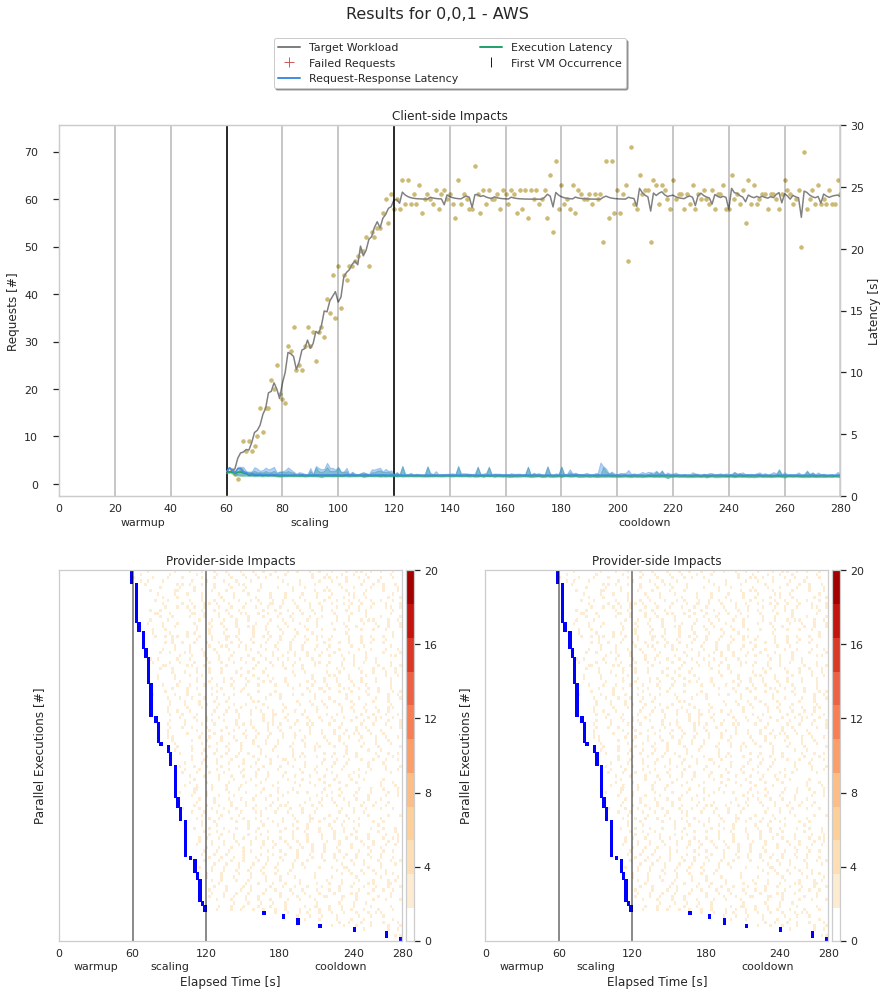

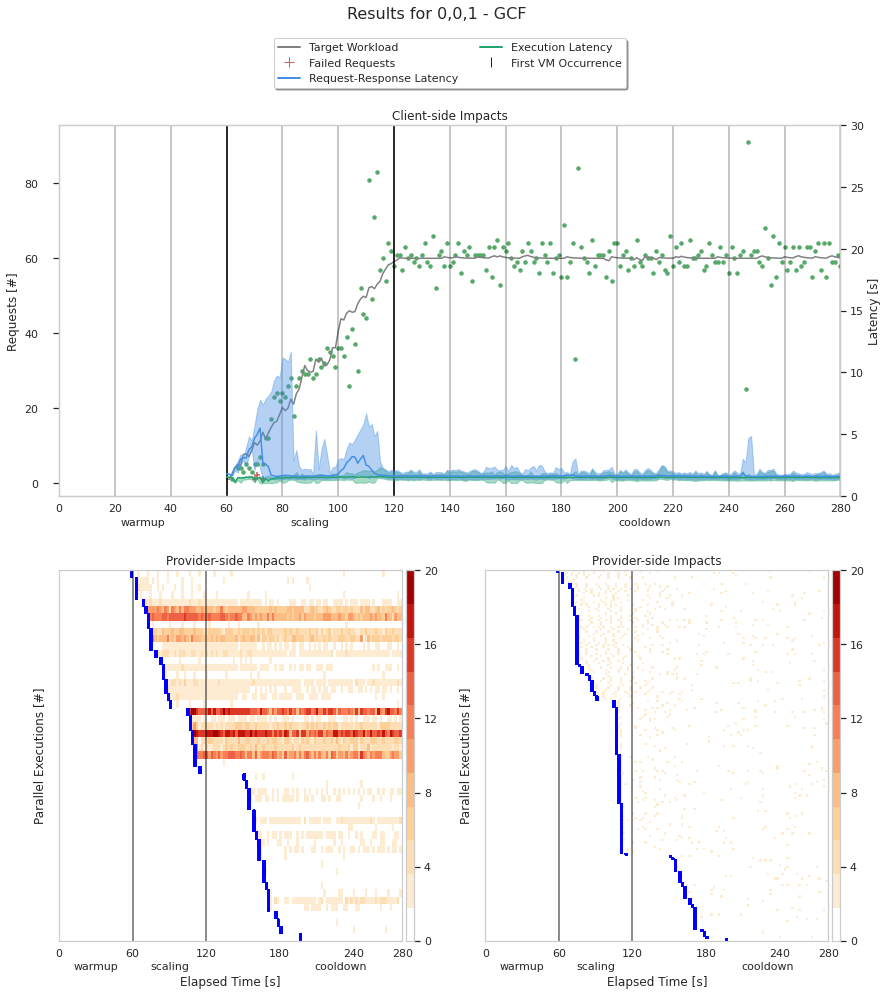

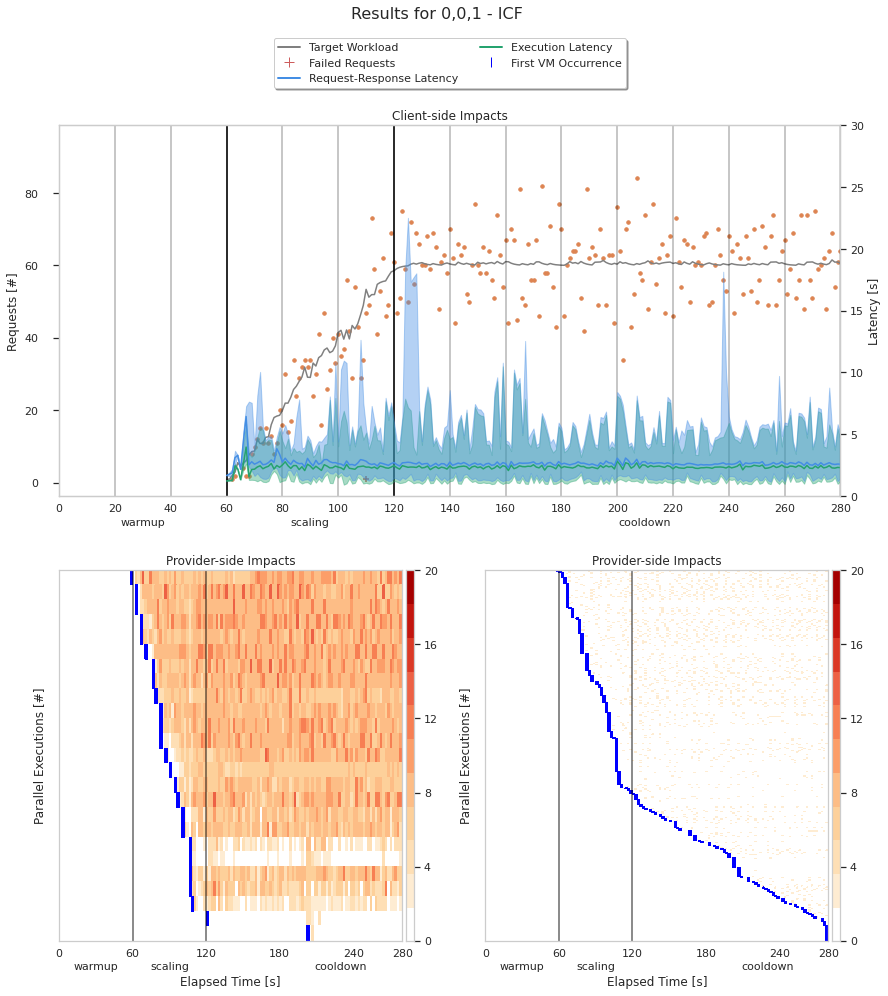

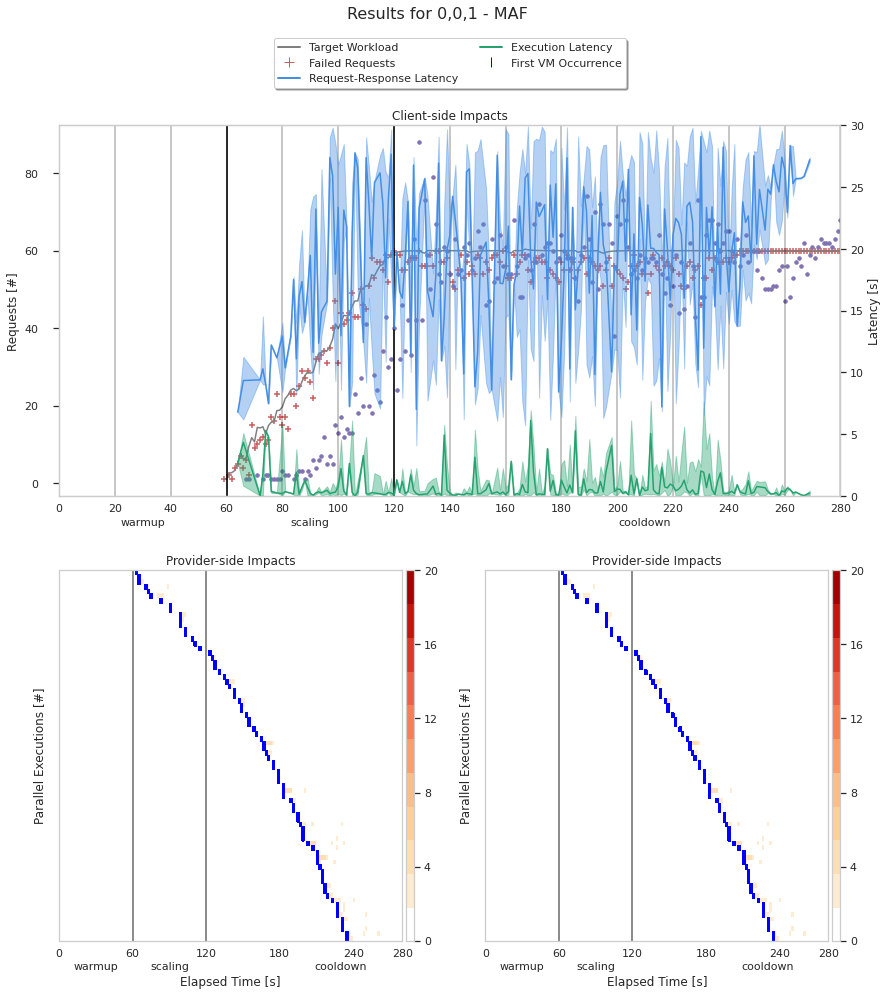

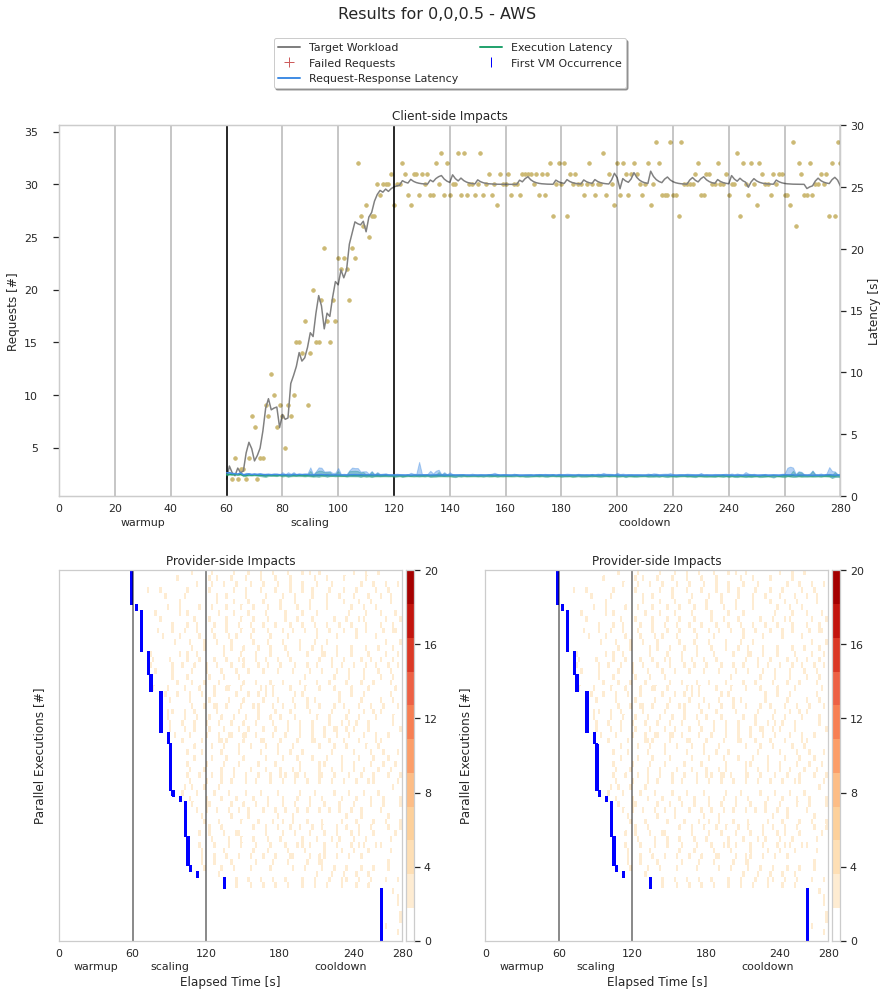

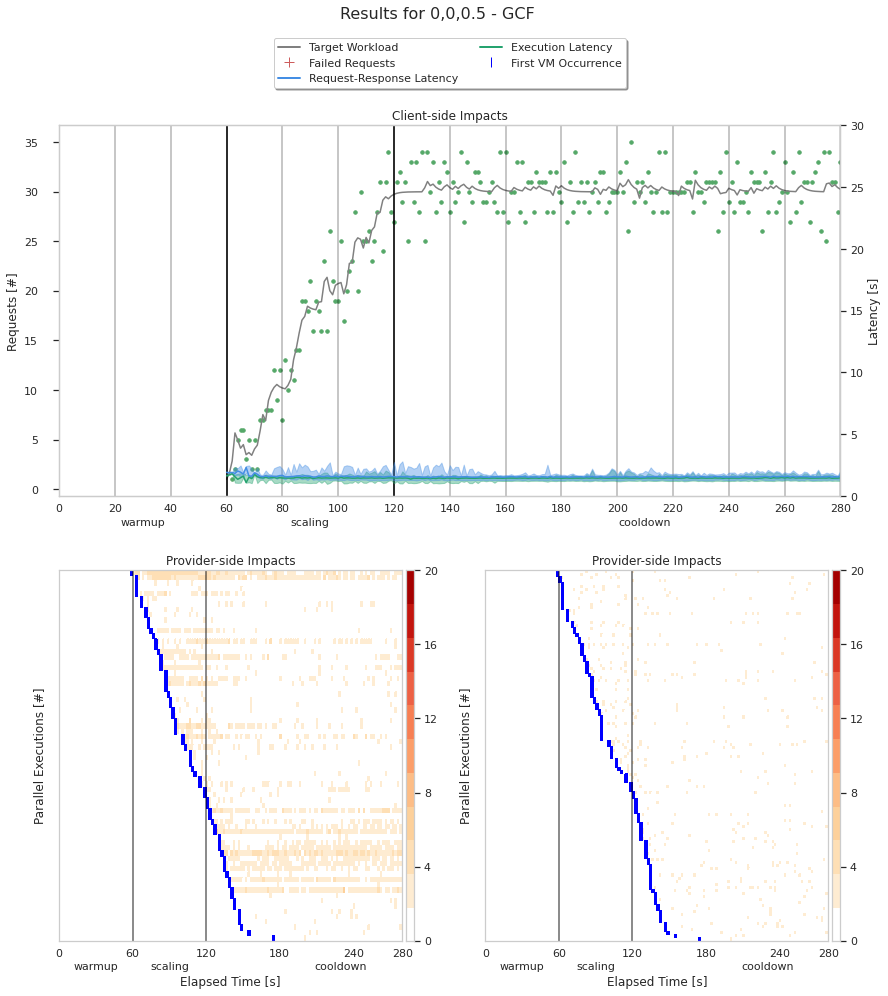

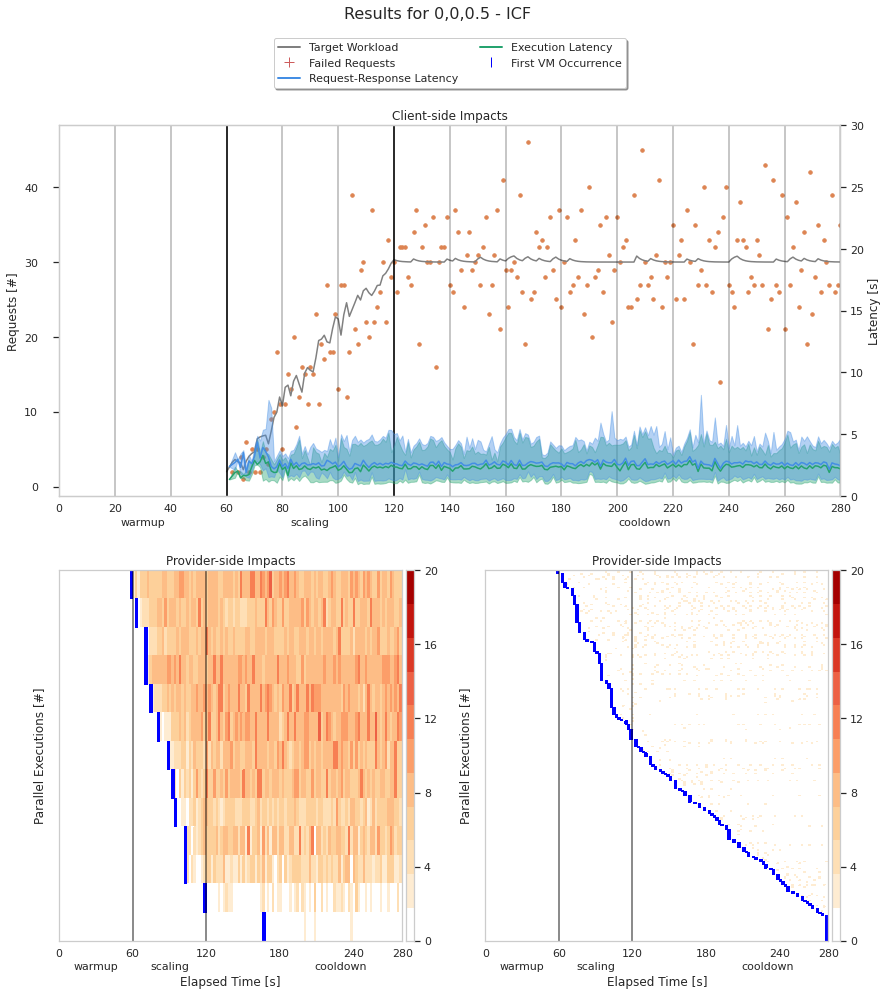

/usr/lib/python3.8/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


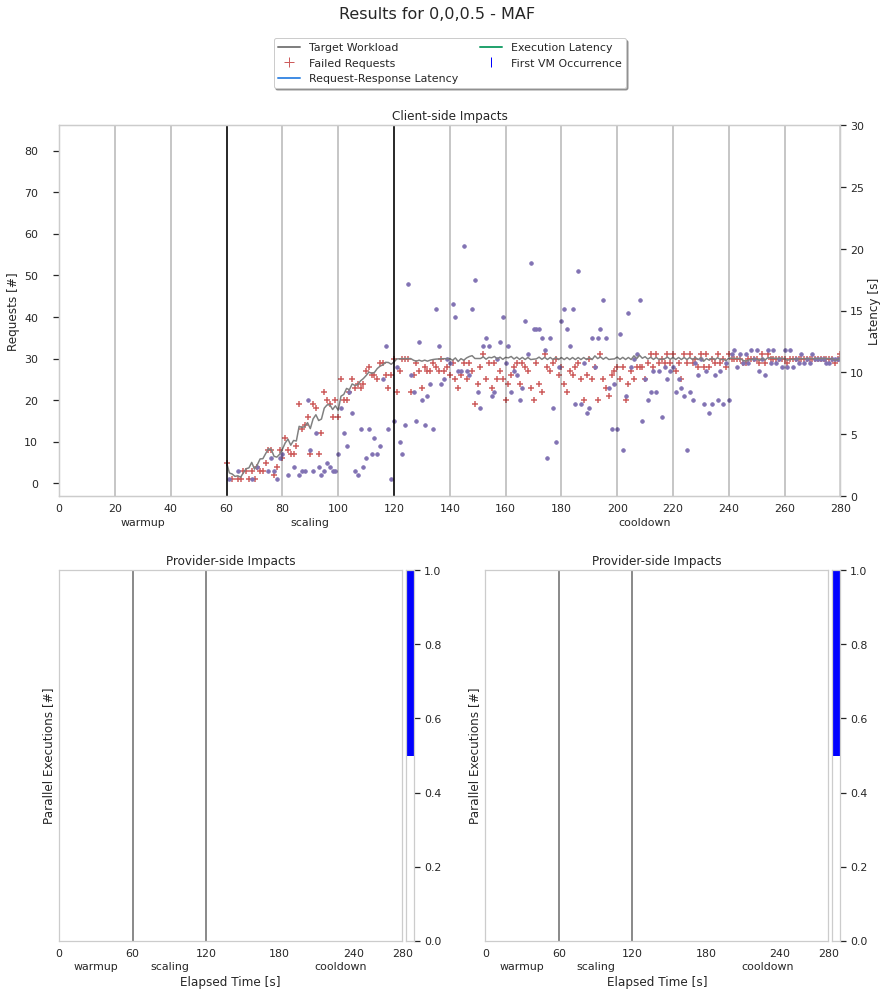

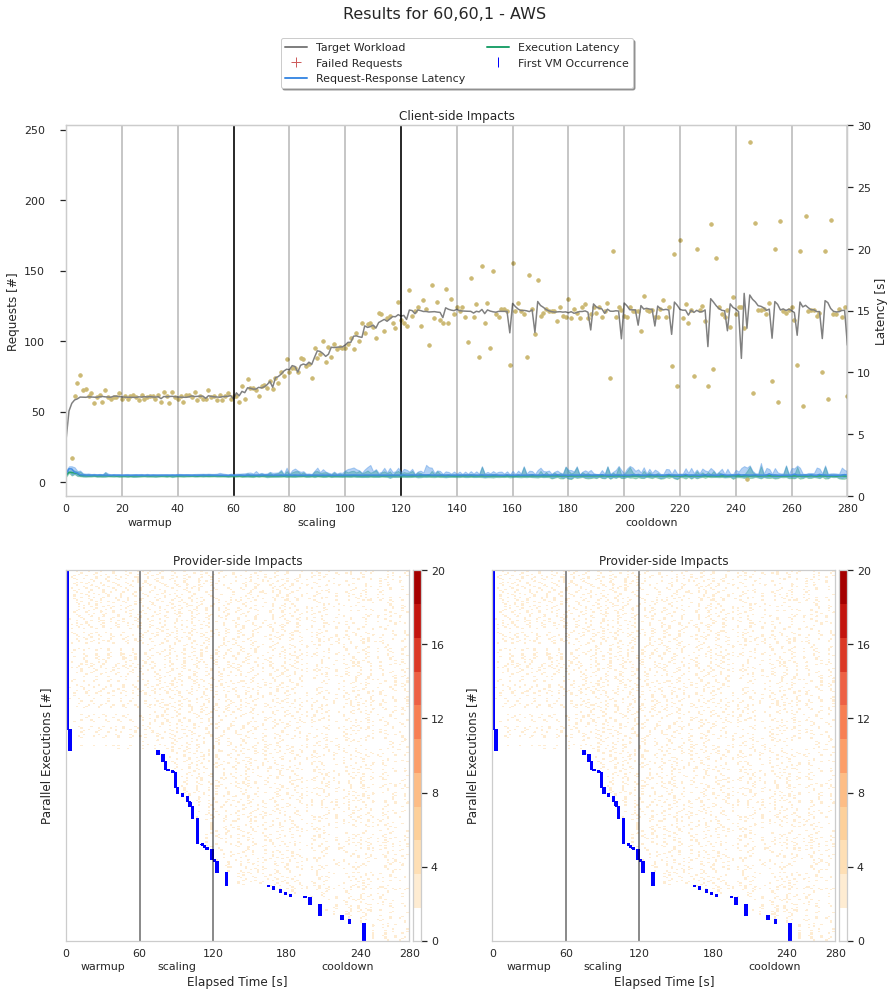

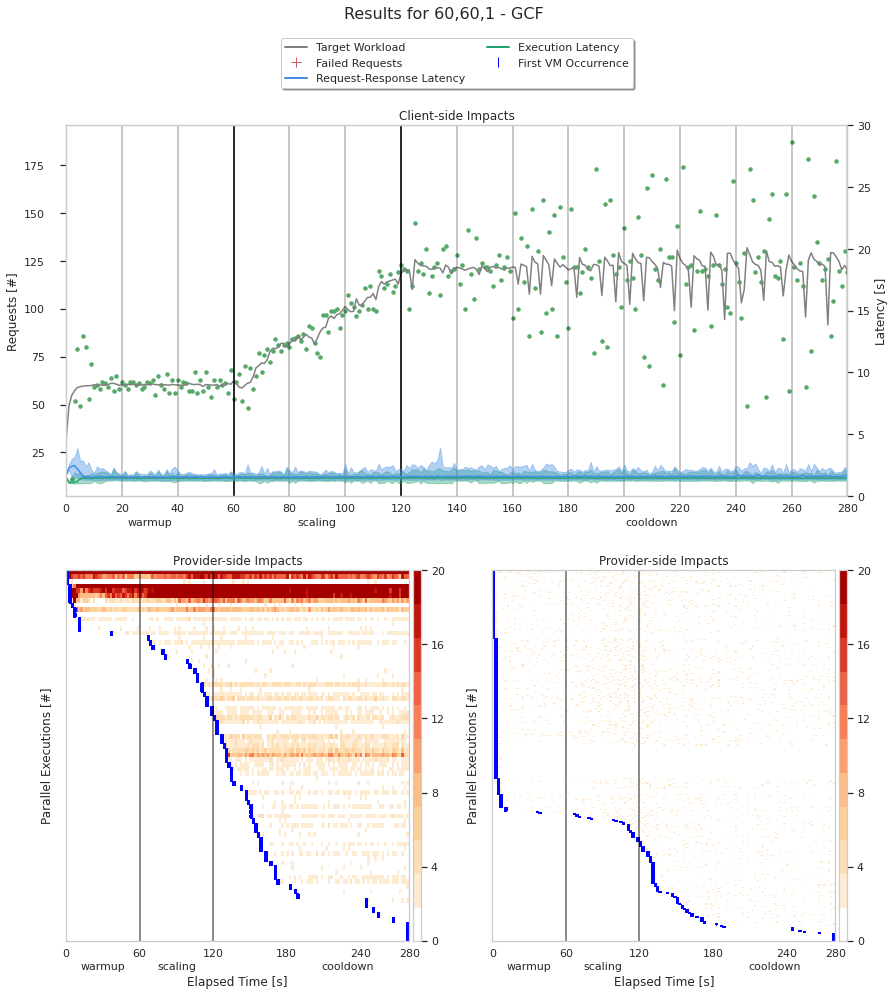

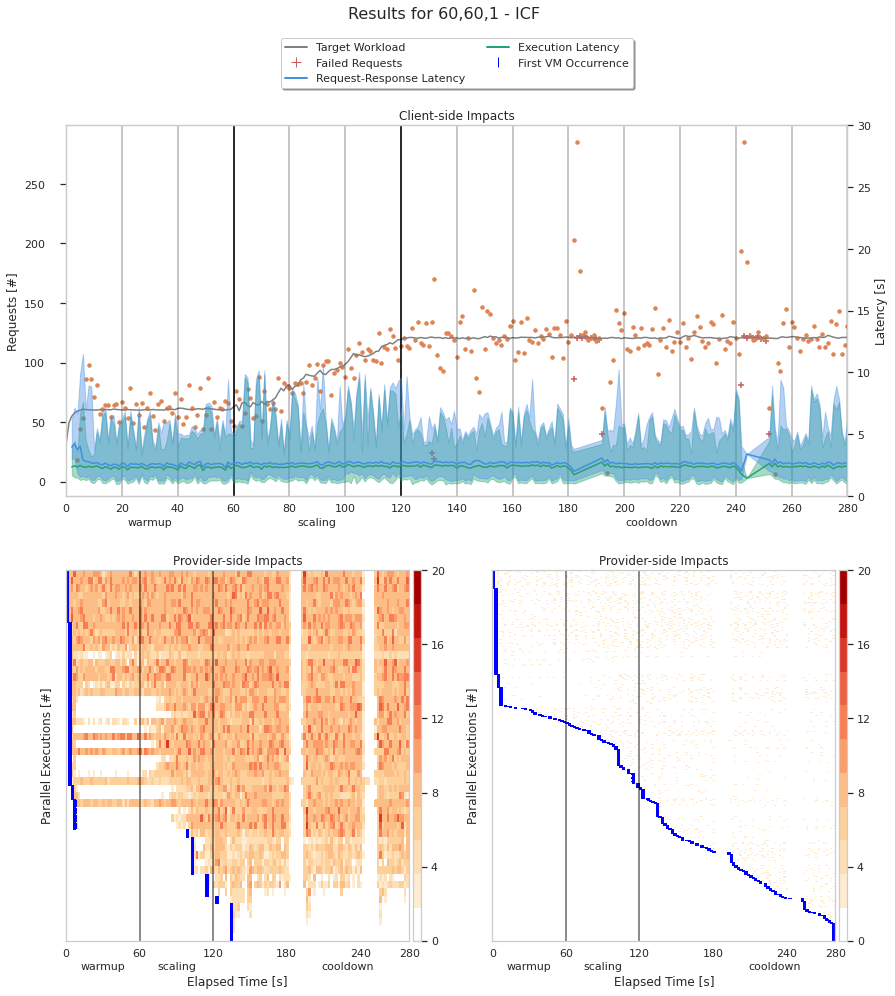

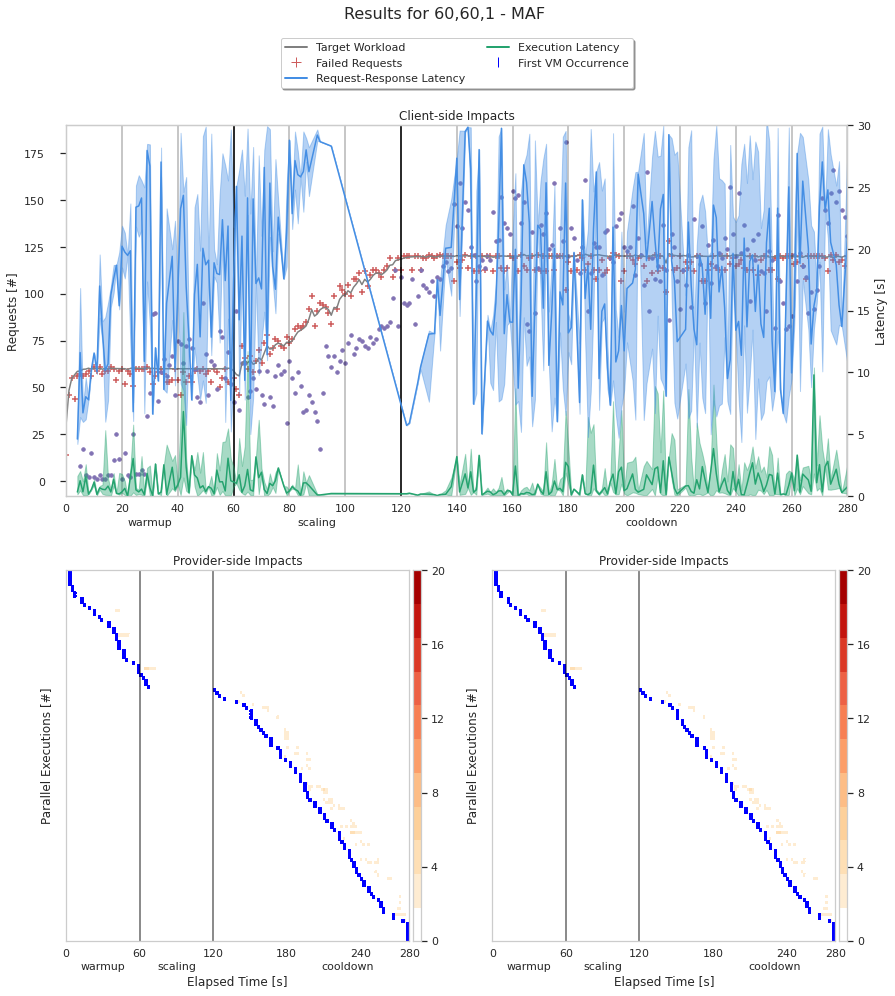

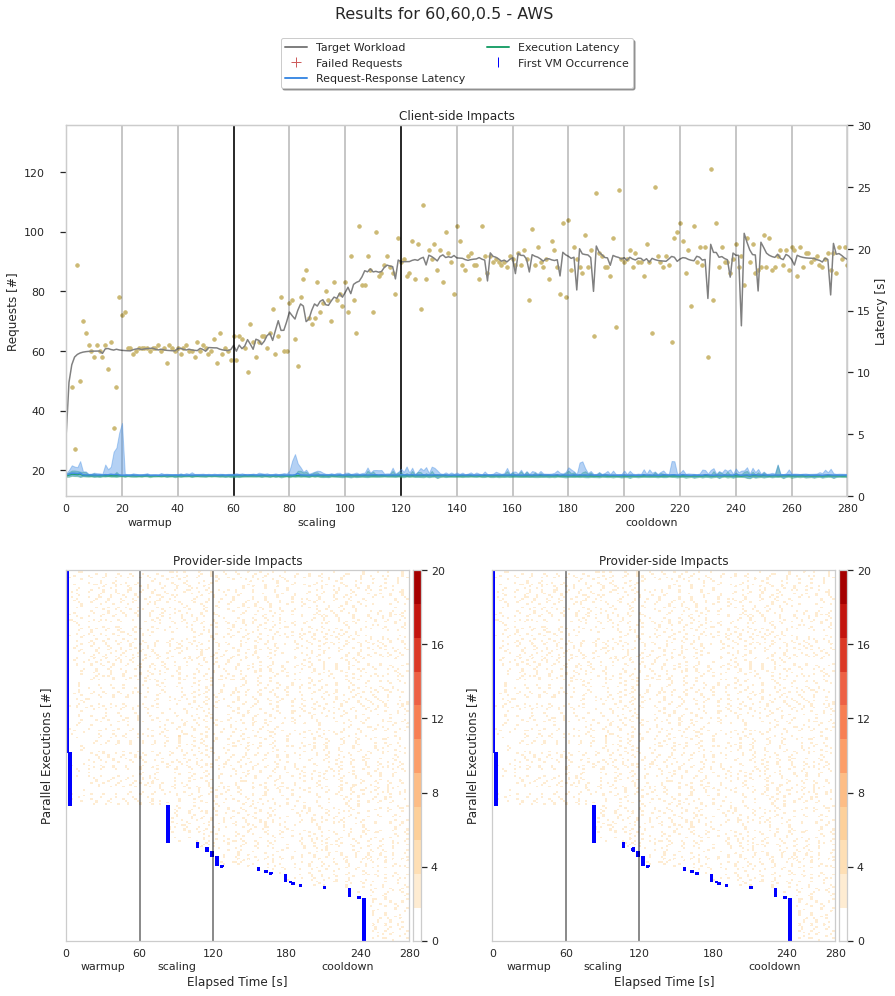

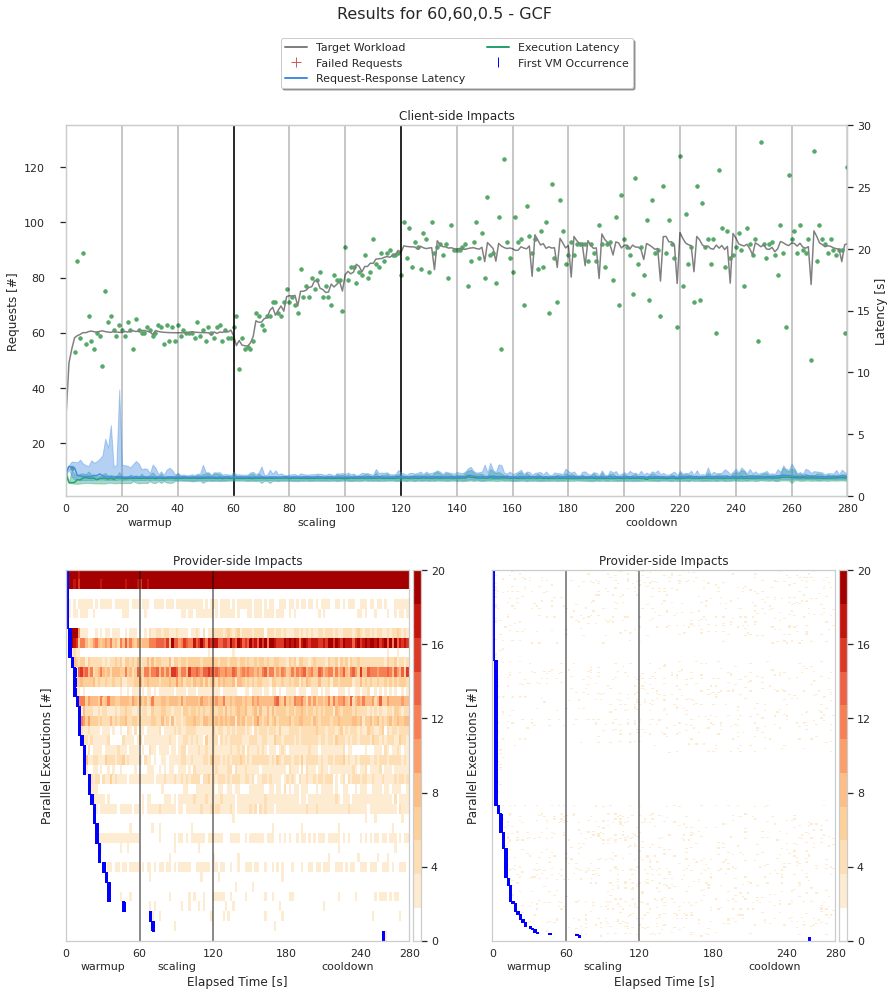

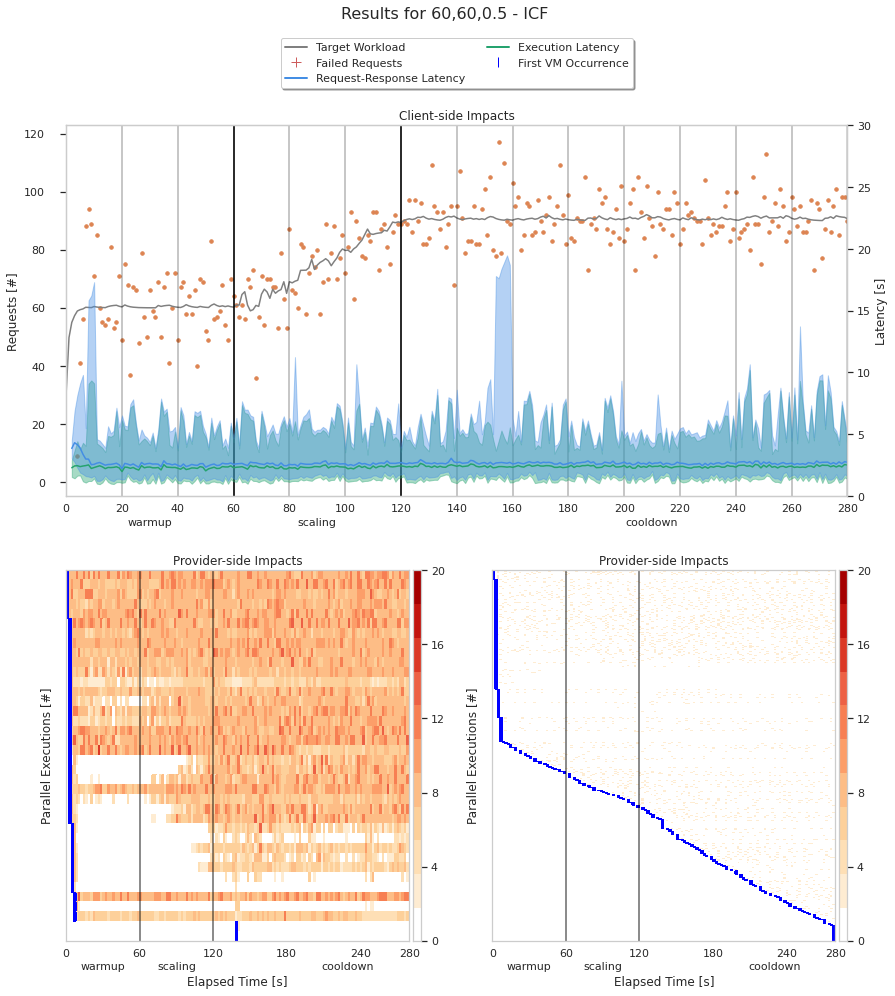

/usr/lib/python3.8/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


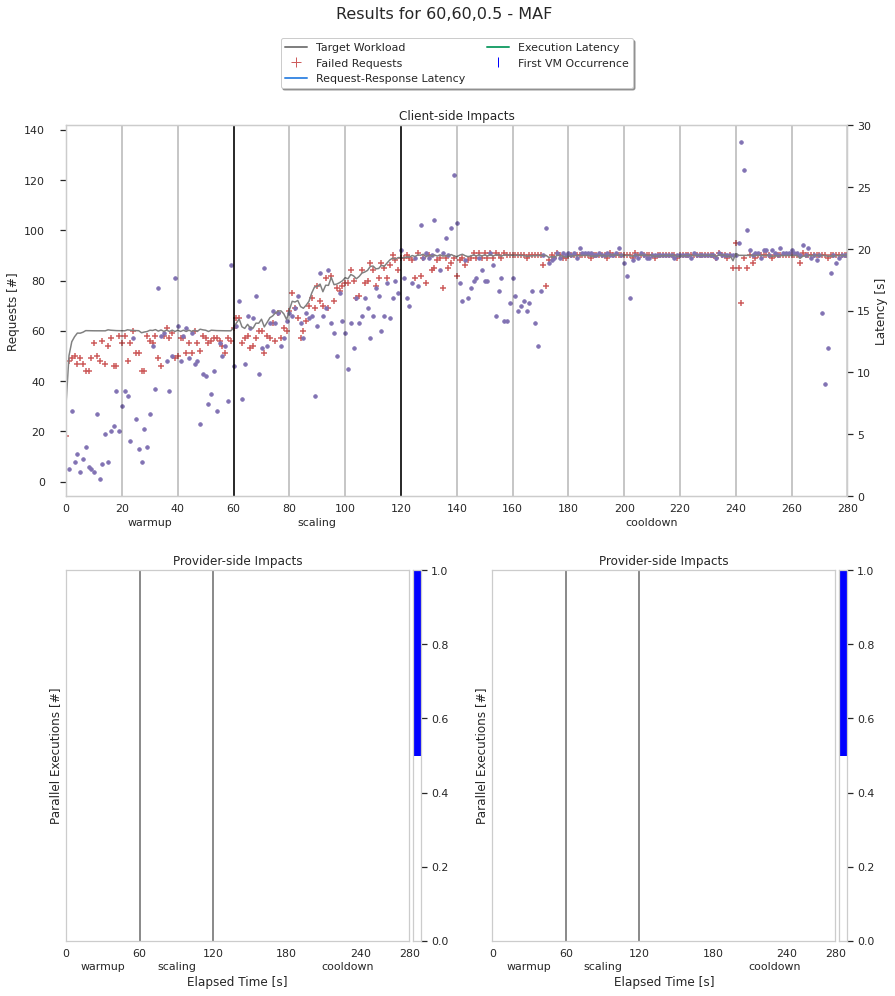

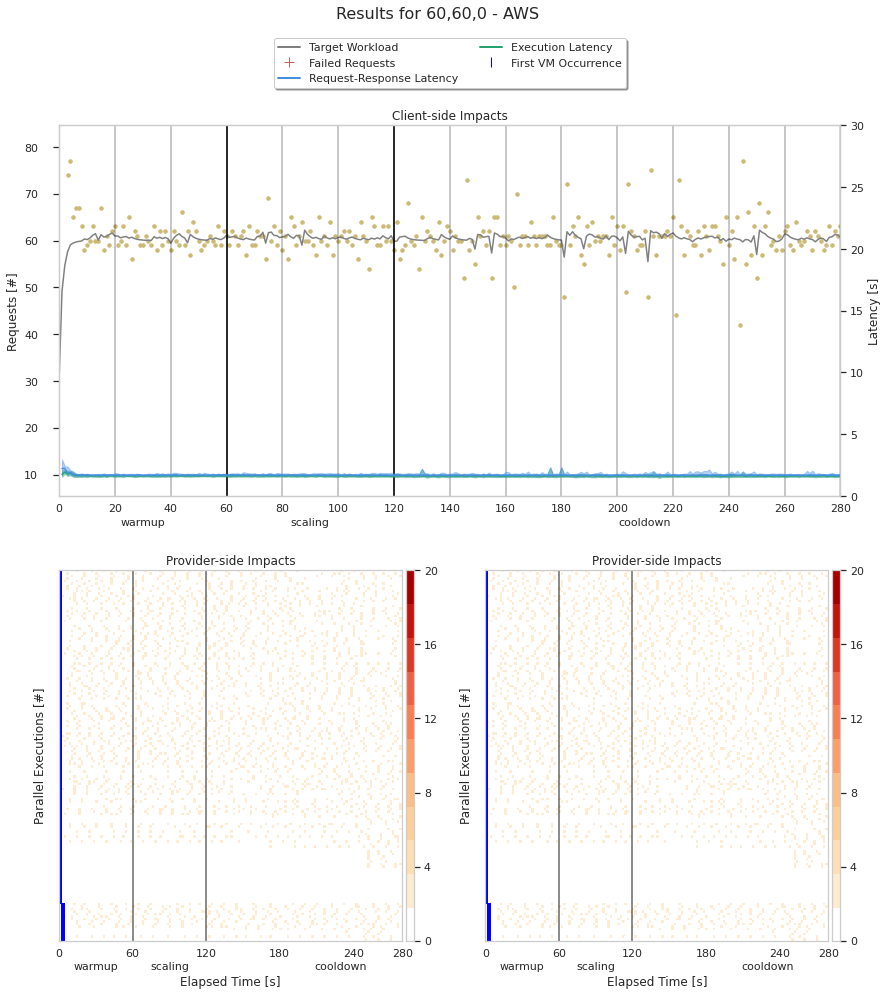

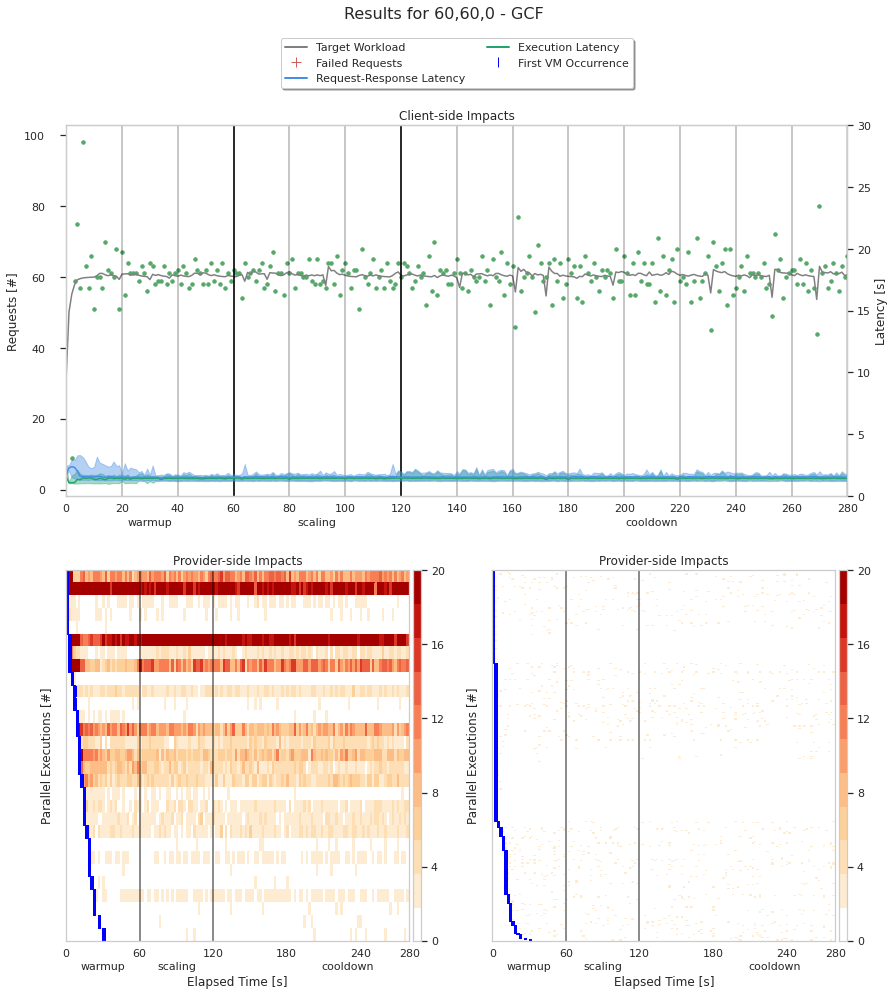

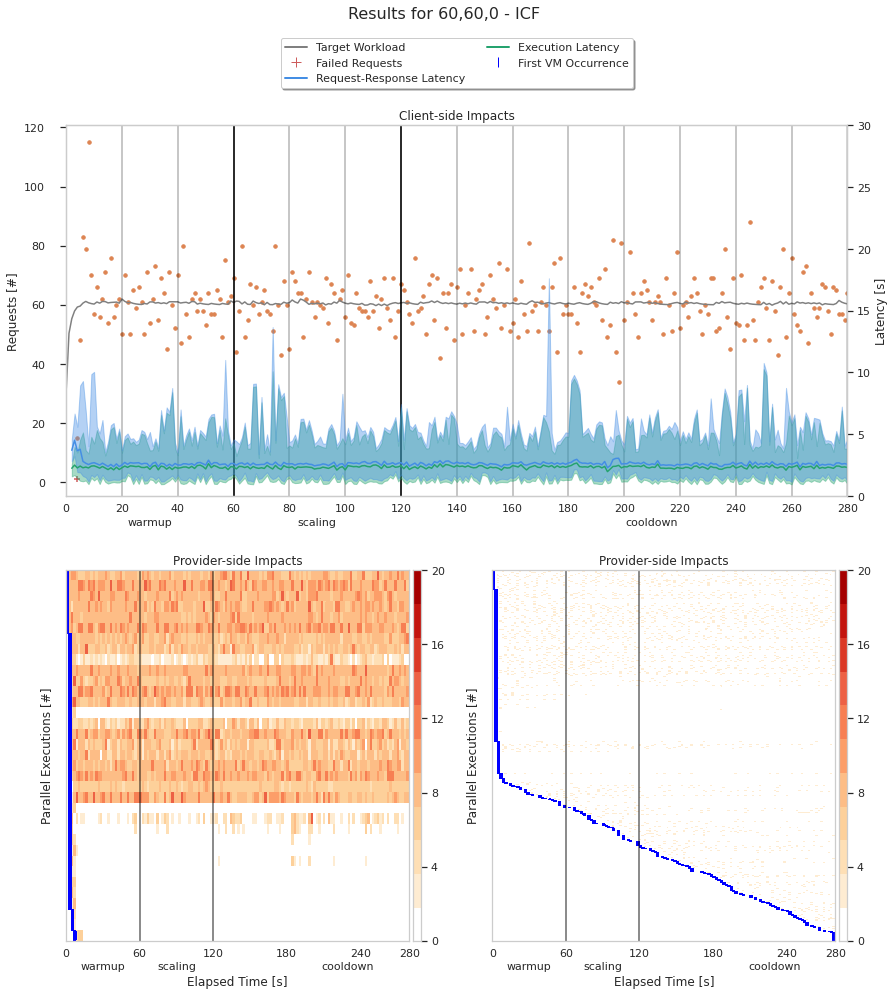

/usr/lib/python3.8/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


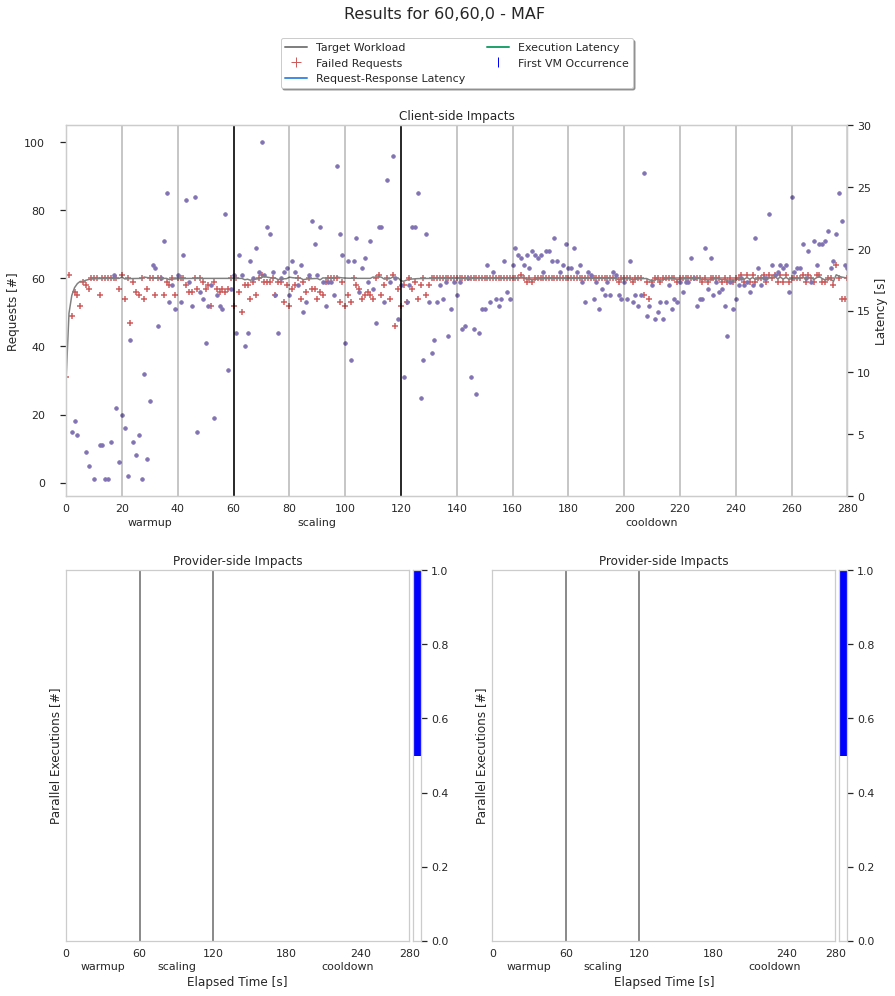

In [13]:
heatmap_cache ={}

with PdfPages("reports/overview_tall.pdf") as pdf:
    for workload in configs:
        for provider in providers:
            fig = plt.figure(figsize=(14,15))
            gs = fig.add_gridspec(ncols=2, nrows=2)
            plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
            ax = fig.add_subplot(gs[0, 0:2])
            plotClientSideOverview(ax,all_280,provider,workload,style=style,ylim=ylims[provider][workload],
                                   xlim=[0,280],with_thruput=True,title="Client-side Impacts",legend=False)
            legendShapes = [
                Line2D([0], [0], color="gray", lw=2),
                Line2D([0], [0], marker='+', lw=0,color='indianred',markerfacecolor='indianred', markersize=10),
                Line2D([0], [0], color=style["Lats"]["RLat"], lw=2),
                Line2D([0], [0], color=style["Lats"]["ELat"], lw=2),
                Line2D([0], [0], marker='|', lw=0,color='blue',markerfacecolor='blue', markersize=10)
            ]
            legendNames = ["Target Workload","Failed Requests",style["Names"]["RLat"],style["Names"]["ELat"],"First VM Occurrence"]
            ax.legend(legendShapes, legendNames,
                loc='upper center', bbox_to_anchor=(0.5, 1.25),fancybox=True, shadow=True, ncol=2)
            ax.set_xlabel(None)
            ax = fig.add_subplot(gs[-1, 0])
            plotHeatmap(ax,all_280,provider,workload,style,selector="HId",cutoff=cutoff,xlim=[0,280],
                        legend=False,title="Provider-side Impacts",cmap=hmcmp,vmax=vmax,heatmap_cache=heatmap_cache)
            for _, spine in ax.spines.items():
                spine.set_visible(True)

            ax = fig.add_subplot(gs[-1, 1])
            plotHeatmap(ax,all_280,provider,workload,style,selector="CId",cutoff=cutoff,xlim=[0,280],
                        legend=False,title="Provider-side Impacts",cmap=hmcmp,vmax=vmax,heatmap_cache=heatmap_cache)
            for _, spine in ax.spines.items():
                spine.set_visible(True)
            #plt.tight_layout()
            pdf.savefig(fig, bbox_inches="tight")
            fig.savefig("reports/overview_tall_{}_{}.pdf"
                .format(style[provider]["name"],workload)
                        , bbox_inches="tight"
            )
            plt.show()
            plt.close(fig)

## Paper Plots

In [26]:
skip = True
if not skip:  
    fig = plt.figure(figsize=(16,15))
    gs = fig.add_gridspec(ncols=2, nrows=2)
    #plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
    provider = "aws"
    workload="0,0,2"
    ax = fig.add_subplot(gs[0, 0])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL2 Client-View")
    ax = fig.add_subplot(gs[-1, 0])

    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("WL2 Platform-View".format(style[provider]["name"],workload))
    provider_view_legend(ax)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    workload="60,60,1"
    ax = fig.add_subplot(gs[0, 1])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL4 Client-View")
    ax = fig.add_subplot(gs[-1, 1])
    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("")
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.set_title("WL4 Platform-View")
    provider_view_legend(ax)
    plt.tight_layout()
    fig.savefig("reports/overview_tall_pair_{}_120.pdf"
        .format(style[provider]["name"])
                , bbox_inches="tight"
    )
    plt.show()
    plt.close(fig)
            

In [27]:
skip = True
if not skip:  
    fig = plt.figure(figsize=(16,15))
    gs = fig.add_gridspec(ncols=2, nrows=2)
    #plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
    provider = "ibm"
    workload="0,0,2"
    ax = fig.add_subplot(gs[0, 0])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL2 Client-View")
    ax = fig.add_subplot(gs[-1, 0])

    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("WL2 Platform-View".format(style[provider]["name"],workload))
    provider_view_legend(ax)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    workload="60,60,1"
    ax = fig.add_subplot(gs[0, 1])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL4 Client-View")
    ax = fig.add_subplot(gs[-1, 1])
    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("")
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.set_title("WL4 Platform-View")
    provider_view_legend(ax)
    plt.tight_layout()
    fig.savefig("reports/overview_tall_pair_{}_120.pdf"
        .format(style[provider]["name"])
                , bbox_inches="tight"
    )
    plt.show()
    plt.close(fig)
            

In [28]:
skip = True
if not skip:  
    fig = plt.figure(figsize=(16,15))
    gs = fig.add_gridspec(ncols=2, nrows=2)
    #plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16,y=0.99)
    provider = "gcf"
    workload="0,0,0.5"
    ax = fig.add_subplot(gs[0, 0])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL0 Client-View")
    ax = fig.add_subplot(gs[-1, 0])

    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("WL0 Platform-View".format(style[provider]["name"],workload))
    provider_view_legend(ax)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    workload="0,0,2"
    ax = fig.add_subplot(gs[0, 1])
    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workload,title=None,
                           legend=None,xlim=[0,280],ylim=ylims[provider][workload])
    client_view_legend(ax2)
    ax.set_xlabel(None)
    ax.set_title("WL2 Client-View")
    ax = fig.add_subplot(gs[-1, 1])
    plotHeatmap(ax,all_280,provider,workload,cutoff=cutoff,xlim=[0,280],
                legend=False,title=None,cmap=hmcmp,vmax=vmax,show_cba=False)
    ax.set_title("")
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    ax.set_title("WL2 Platform-View")
    provider_view_legend(ax)
    plt.tight_layout()
    fig.savefig("reports/overview_tall_pair_{}_120.pdf"
        .format(style[provider]["name"])
                , bbox_inches="tight"
    )
    plt.show()
    plt.close(fig)
            

In [29]:
skip = True
if not skip:
    provider = "azure"
    workloads = ["0,0,0.5","0,0,1","60,60,0.5","60,60,1"]

    fig = plt.figure(figsize=(16,15))
    gs = fig.add_gridspec(ncols=2, nrows=2)
    ax = fig.add_subplot(gs[0, 0])

    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workloads[0],title=None,
                               legend=None,xlim=[0,280],ylim=ylims[provider][workloads[0]])
    client_view_legend(ax2)
    ax.set_title("WL0 Client-View")
    ax = fig.add_subplot(gs[0, 1])

    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workloads[1],title=None,
                               legend=None,xlim=[0,280],ylim=ylims[provider][workloads[1]])
    client_view_legend(ax2)
    ax.set_title("WL1 Client-View")
    ax = fig.add_subplot(gs[-1, 0])

    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workloads[2],title=None,
                               legend=None,xlim=[0,280],ylim=ylims[provider][workloads[2]])
    client_view_legend(ax2)
    ax.set_title("WL3 Client-View")
    ax = fig.add_subplot(gs[-1, -1])

    ax,ax2 = plotClientSideOverview(ax,all_280,provider,workloads[3],title=None,
                               legend=None,xlim=[0,280],ylim=ylims[provider][workloads[3]])
    client_view_legend(ax2)
    ax.set_title("WL4 Client-View")

    plt.tight_layout()
    fig.savefig("reports/{}_overview.pdf"
            .format(style[provider]["name"])
                    , bbox_inches="tight"
    )

## Table

In [30]:
successfuls = all_280[all_280["RCode"] == 200]
successfuls["EStart_s"] = round(successfuls["EStart"]/1000)
successfuls["EEnd_s"] = round(successfuls["EEnd"]/1000)

workload = "0,0,1"
provider = "aws"

#successfuls[(successfuls["Provider"] == provider) & (successfuls["WL"] == workload)]["HId"].unique()

In [31]:
#format workload_i+provider_i*len(providers),second

foo = successfuls.groupby(["WL","Provider","RId"])

In [32]:
hids = np.zeros((len(configs)*len(providers),280))
requests = np.zeros((len(configs)*len(providers),280))

In [33]:
for wi in range(0,len(configs)):
    for pi in range(0,len(providers)):
        idx = wi+pi*len(providers)
        provider = providers[pi]
        workload = configs[wi]
        data = successfuls[(successfuls["Provider"] == provider) & (successfuls["WL"] == workload)]
        x = data.groupby(["WL","Provider","HId"])["EStart_s"].min().reset_index(name="first_start")
        x = x.groupby(["WL","Provider","first_start"])["HId"].count().cumsum().reset_index()
        for i in range(0,len(data)):
            for r in range(int(data.iloc[i]["EStart_s"]),int(data.iloc[i]["EEnd_s"])):
                if r < 280:
                    requests[idx,r] +=1
        for i in range(0,len(x)-1):
            a = x.iloc[i]
            b = x.iloc[i+1]
            for r in range(int(a["first_start"]),int(b["first_start"])):
                hids[idx,r] = a["HId"]

In [34]:
le_tabel = []
clms = []
for wi in range(0,len(configs)):
    for pi in range(0,len(providers)):
        idx = wi+pi*len(providers)
        provider = providers[pi]
        workload = configs[wi]
        clms.append("{} {}".format(provider,workload))
    

In [35]:
pd.DataFrame(hids,index=clms).to_csv("reports/hids.csv")
pd.DataFrame(requests,index=clms).to_csv("reports/requests.csv")

In [94]:
X = all.groupby(["Provider","WL"])[["HId","CId"]].apply(lambda x:

[
     len(x)/len(x["HId"].unique() ),
    len(x)/len(x["CId"].unique()),
    (len(x)/len(x["CId"].unique()))/(len(x)/len(x["HId"].unique()))
])
X.to_dict()


{('aws', '0,0,0.5'): [99.109375, 99.109375, 1.0],
 ('aws', '0,0,1'): [111.50877192982456, 111.50877192982456, 1.0],
 ('aws', '60,60,1'): [111.66181818181818, 111.66181818181818, 1.0],
 ('gcf', '0,0,0.5'): [90.92857142857143,
  52.17213114754098,
  0.5737704918032787],
 ('gcf', '0,0,1'): [243.21153846153845, 76.1867469879518, 0.3132530120481928],
 ('gcf', '60,60,1'): [388.7848101265823,
  87.25568181818181,
  0.22443181818181818]}